In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
# matplotlib.rcParams["font.family"] = 'sans-serif'
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math
import numpy as np
import itertools
from scipy.stats import bootstrap, beta
from joblib import Parallel, delayed
from scipy.special import beta as B

### Case 1: IID

Given the observed data $x_1, \dots, x_t$, we consider the following estimates.

MLE:

$$\hat p_s = \frac{1}{t} \sum_{r = 1}^t x_i, \ \forall s > t$$

MAP: 

$$\hat p_s = \frac{\alpha + \sum_{r = 1}^t x_i - 1}{\alpha + \beta + t - 2}, \ \forall s > t$$

MAP + Prospection:

Let $\hat p_t$ be the MAP estimate based on the original observations $x_1, \dots, x_t$. Let $\hat p_t^b$ be the bootstrap MAP estimate from the bootstrap sample $b$. We consider $B$ such bootstrap samples. Define, 
$$ \Delta = | \hat p_t - \text{mean}(\hat p_t^1, \dots, \hat p_t^B) |. $$
The estimates for future time steps $s > t$ is then given by,
$$ \hat p_s = \hat p_t + \dot{\Delta} (s - t), \ \forall s > t $$

In [5]:
class Learners:
    def __init__(self, data=None, t=None, T=None, mode=0.5, conc=10) -> None:
        self.t = t
        self.T = T
        self.alpha, self.beta = self.compute_alpha_beta(mode, conc)
        self.data = data
        self.thresh = 0.5
        self.mode = mode
        self.delta_dot = 0
        if data is not None:
            self.p_mle = self.compute_mle(data)
            self.p_map = self.compute_map(data)
            self.pred_post_dist = self.compute_pred_post_dist(data)
            self.p_prol = self.compute_prospective_map(data)

    def compute_alpha_beta(self, mode, conc):
        alpha = mode * (conc - 2) + 1
        beta = (1 - mode) * (conc - 2) + 1
        return alpha, beta
        
    def compute_mle(self, data):
        return np.mean(data)

    def compute_map(self, data):
        nom = self.alpha + np.sum(data) - 1
        denom = self.alpha + self.beta + self.t - 2
        return nom/denom
    
    def compute_pred_post_dist(self, data):
        nom = B(self.alpha + np.sum(data) + 1, self.beta + self.t - np.sum(data) - 1)
        denom = B(self.alpha + np.sum(data) - 1, self.beta + self.t - np.sum(data) - 1)
        return nom/denom
    
    def compute_delta_dot(self, p, t):
        alpha_1 = self.alpha - 1
        beta_1 = self.beta - 1
        t_1 = t - 1
        r1 = (alpha_1 + t*p)/(alpha_1 + beta_1 + t)
        r2 = (alpha_1 + t_1*p)/(alpha_1 + beta_1 + t_1)
        return r1 - r2
    
    def compute_prospective_map(self, data):
        p = self.p_map

        delta_dots = [self.compute_delta_dot(p, r) for r in np.arange(self.t+1, self.T, 1)]
        self.delta_dot = self.compute_delta_dot(p, self.t)
        int_delta_dots = np.array([np.sum(delta_dots[:r+1]) for r in range(len(delta_dots))])
        p_hat_s = p + int_delta_dots

        return p_hat_s

class Process:
    def __init__(self, func, T) -> None:
        self.p = np.array([func(s) for s in np.arange(1, T, 1)])
        self.t = None
        self.T = T
        pass

    def sample_from_process(self, range: list[float], reps: int):
        self.t = range[1]
        p = self.p[range[0]-1:range[1]]
        p = p * np.ones((reps, len(p)))
        return np.random.binomial(n=1, p=p)

    def loss(self, pred):
        truth = self.p[self.t: self.T]
        term_0 = (1-truth) * np.log(1-pred + 1e-7)
        term_1 = truth * np.log(pred + 1e-7)
        return - term_0 - term_1
    
    # def loss(self, pred):
    #     truth = self.p[self.t: self.T]
    #     return (truth - pred)**2

In [6]:
# run a replicate
def run_replicate(t, T, func, prior_mode, prior_conc):
    process = Process(func, T)
    past_data = process.sample_from_process([1, t], 1)  

    L = Learners(past_data, t, T, prior_mode, prior_conc)  

    return process.loss(L.p_mle), process.loss(L.p_map), process.loss(L.p_prol)

In [41]:
# params

# func = lambda t : 1 - 0.5 ** (0.3*t) # smoothly increasing 
func = lambda t : 0.8 # fixed 
# func = lambda t : 0.5 + 0.3*np.sin(t) # sinusoid
# func = lambda t : 0.8 if t % 2 == 1 else 0.2 # ABAB

T = 20
t_list = np.arange(1, T, 1)
prior_mode = 0.1
prior_conc = 15
reps = 1000

In [42]:
sqd_errs_at_s = []
avg_sqd_err = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(run_replicate)(t, T, func, prior_mode, prior_conc) for _ in range(reps))
    tmp = np.array(tmp)
    sqd_errs_at_s.append(np.mean(tmp, axis=0))
    avg_sqd_err.append(np.mean(tmp, axis=(0, 2)))
avg_sqd_err = np.array(avg_sqd_err)

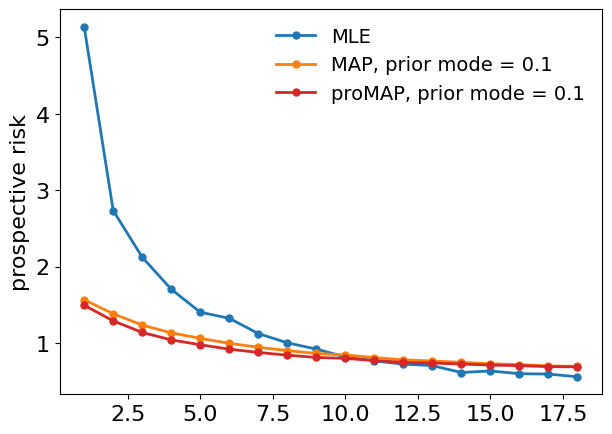

In [45]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1], sns.color_palette("tab10")[3]]

labels = ['MLE', f'MAP, prior mode = {prior_mode}', f'proMAP, prior mode = {prior_mode}']
for i, label in enumerate(labels):
    ax.plot(t_list, avg_sqd_err[:, i], 
            label=f'{label}', 
            color=colors[i], marker='o', ms=5, lw=2)
ax.set_ylabel('prospective risk')
ax.legend(frameon=False, fontsize=14)

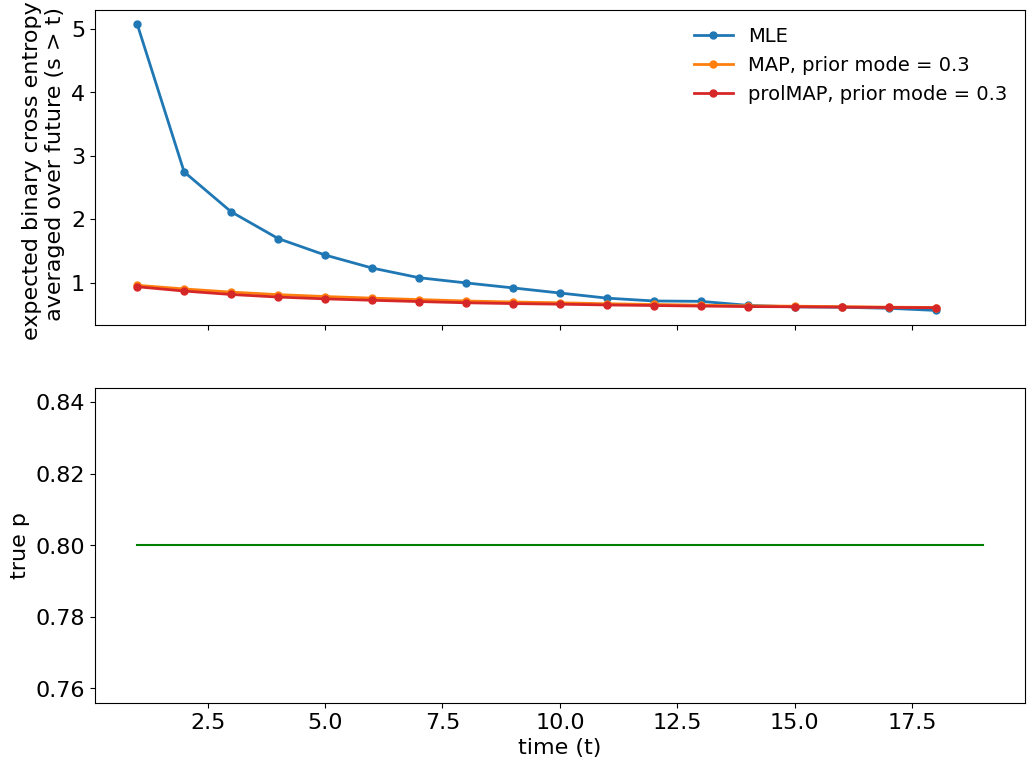

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1], sns.color_palette("tab10")[3]]

ax = axes[0]
labels = ['MLE', f'MAP, prior mode = {prior_mode}', f'prolMAP, prior mode = {prior_mode}']
for i, label in enumerate(labels):
    ax.plot(t_list, avg_sqd_err[:, i], 
            label=f'{label}', 
            color=colors[i], marker='o', ms=5, lw=2)
ax.set_ylabel('expected binary cross entropy \n averaged over future (s > t)')
ax.legend(frameon=False, fontsize=14)

ax = axes[1]
process = Process(func, T)
ax.plot(t_list, process.p, color='g')
ax.set_xlabel('time (t)')
ax.set_ylabel('true p')

plt.show()

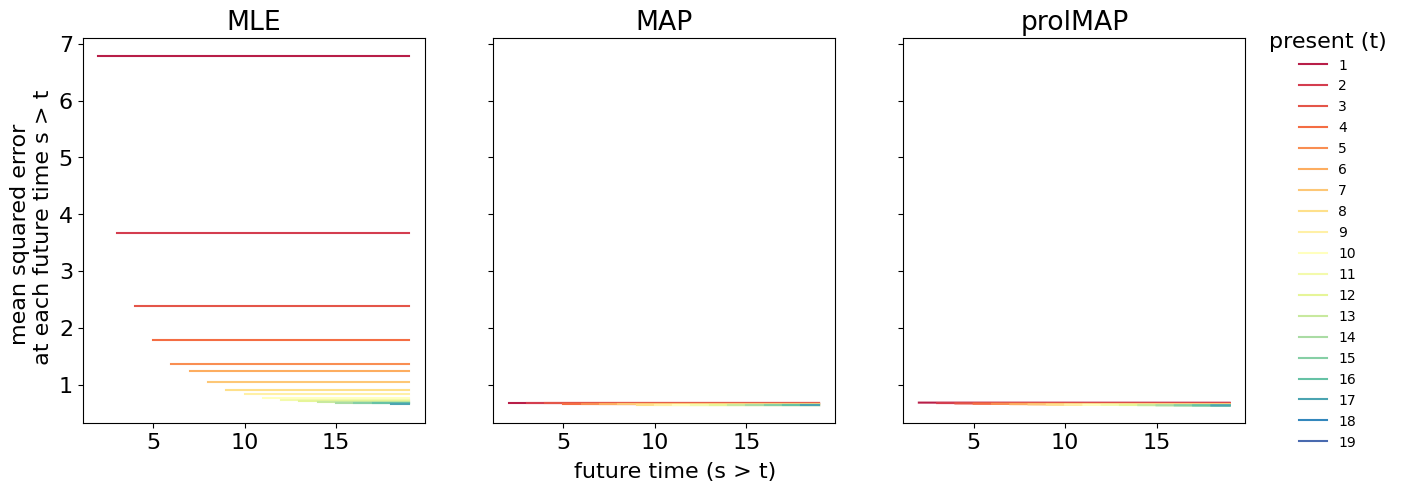

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey='row')
colors = sns.color_palette("Spectral", n_colors=len(sqd_errs_at_s))
for i, t in enumerate(t_list):
    ax[0].plot(t_list[i+1:], sqd_errs_at_s[i][0, :], color=colors[i], label=f'{t}')
    ax[0].set_title('MLE')
    ax[1].plot(t_list[i+1:], sqd_errs_at_s[i][1, :], color=colors[i], label=f'{t}')
    ax[1].set_title('MAP')
    ax[2].plot(t_list[i+1:], sqd_errs_at_s[i][2, :], color=colors[i], label=f'{t}')
    ax[2].set_title('prolMAP')
ax[0].set_ylabel('mean squared error \n at each future time s > t')
ax[2].legend(fontsize=10, loc='best', bbox_to_anchor=(0.95, 0.55, 0.5, 0.5), title='present (t)', frameon=False)
fig.text(0.52, 0.00, 'future time (s > t)', ha='center')
plt.show()

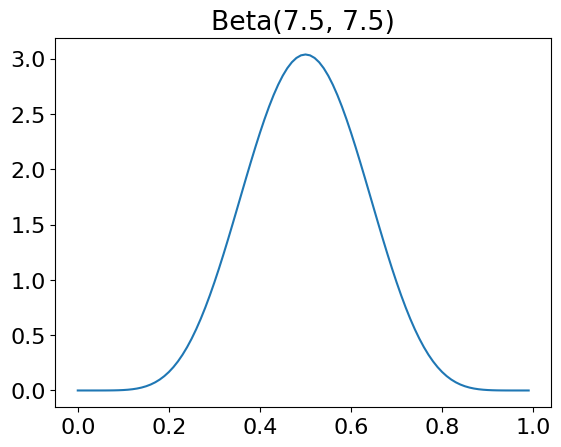

In [22]:
L = Learners(mode=prior_mode, conc=prior_conc)  
plt.plot(np.arange(0, 1, 0.01), beta(L.alpha, L.beta).pdf(np.arange(0, 1, 0.01)))
plt.title(f'Beta({L.alpha}, {L.beta})')
plt.show()

In [14]:
# params
p = 0.8
T = 50
t_list = np.arange(2, T, 2)
prior_mode = 0.3
prior_conc = 15
reps = 1000

In [15]:
def loop(p, t, T, prior_mode, prior_conc): 
    process = Process(func, T)
    past_data = process.sample_from_process([1, t], 1)  
    L = Learners(past_data, t, T, prior_mode, prior_conc)
    return L.p_mle, L.p_map, L.delta_dot

stuff = []
std = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(loop)(p, t, T, prior_mode, prior_conc) for _ in range(reps))
    stuff.append(np.mean(tmp, axis=0))
    std.append(np.std(tmp, axis=0))
stuff = np.array(stuff)
std = np.array(std)

Text(0.5, 0, 'present (t)')

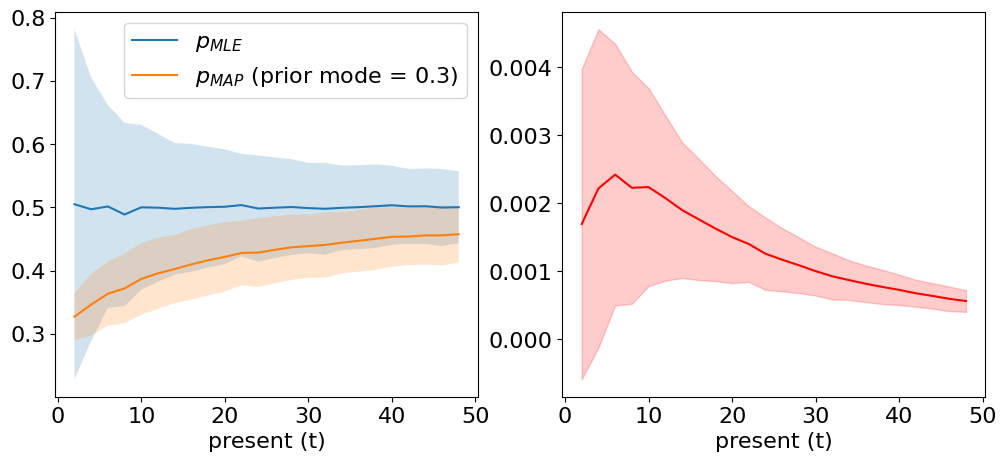

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
labels = [r'$p_{MLE}$', r'$p_{MAP}$' + f' (prior mode = {prior_mode})']
for i, label in enumerate(labels):
    ax[0].plot(t_list, stuff[:, i], label=label)
    ci = std[:, i] 
    ax[0].fill_between(t_list, stuff[:, i]-ci, stuff[:, i]+ci, alpha=0.2)
ax[0].legend()
ax[0].set_xlabel('present (t)')

ax[1].plot(t_list, stuff[:, 2], label=r'$\delta(t)$ with $p_{MAP}$', c='r')
ci = std[:, 2]
ax[1].fill_between(t_list, stuff[:, 2]-ci, stuff[:, 2]+ci, alpha=0.2, color='r')
ax[1].set_xlabel('present (t)')

# past_data = sample_from_process(p, (t,))  
# L = Learners(past_data, t, T, prior_mode, prior_conc)
# delta_dot = [L.compute_delta_dot(p, t) for t in t_list]
# ax[1].plot(t_list, delta_dot, label=r'$\delta(t)$ with true p=0.8', c='g')
# ax[1].legend()
# plt.show()

# / np.sqrt(reps) * 1.96